In [1]:
import pandas as pd
import numpy as np

import test_recommender as recommender

In [2]:
df = recommender.load_movies("data/test_movies.csv")
df.head()
df.describe()

,id,cinematography_rating,pacing_rating,music_rating,direction_rating,plot_rating
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,3.650000,2.750000,3.350000,3.800000,3.750000
std,5.91608,0.933302,1.371707,0.812728,0.894427,1.069924
min,1.00000,2.000000,1.000000,2.000000,2.000000,2.000000
25%,5.75000,3.000000,2.000000,3.000000,3.000000,3.000000
50%,10.50000,4.000000,2.000000,3.000000,4.000000,4.000000
75%,15.25000,4.000000,3.250000,4.000000,4.000000,5.000000
max,20.00000,5.000000,5.000000,5.000000,5.000000,5.000000


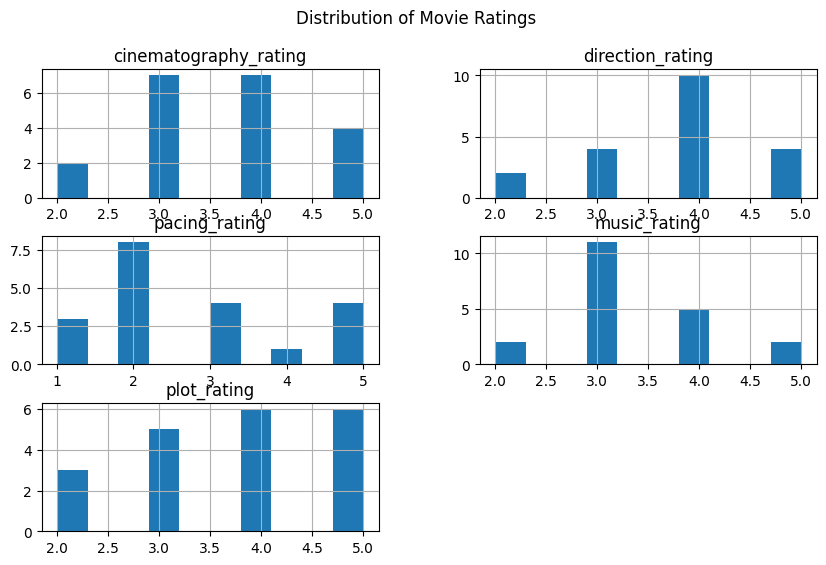

In [3]:
import matplotlib.pyplot as plt

df[[
    "cinematography_rating",
    "direction_rating",
    "pacing_rating",
    "music_rating",
    "plot_rating"
]].hist(figsize=(10,6))
plt.suptitle("Distribution of Movie Ratings")
plt.show()


In [4]:
user_weights = [5,4,3,2,5]
preferred_genres = ["Drama", "Action"]
pacing_pref = "fast"

results, meta = recommender.recommend_movies(
    df,
    user_weights,
    preferred_genres,
    pacing_pref,
    discovery_mode=False,
    top_n=10
)

display(results[["title", "feature_score", "genre_score", "final_score"]])

print("Learning Info:")
print(f"- liked movies used: {meta['n_likes']}")
print(f"- beta (baseline weight): {meta['beta']:.3f}")
print(f"- final user profile: {np.round(meta['final_profile'], 3)}")


,title,feature_score,genre_score,final_score
2,Balanced Drama,0.987346,0.5,0.841142
16,SciFi Thinkpiece,0.981658,0.5,0.837161
8,Indie Character Study,0.979559,0.5,0.835691
19,Director Showcase,0.974684,0.5,0.832278
5,Plot Heavy Mystery,0.963885,0.5,0.824719
14,Slow Mystery Noir,0.962160,0.5,0.823512
10,Romantic Epic,0.955059,0.5,0.818541
0,Slow Art Film,0.955018,0.5,0.818512
17,Classic War Drama,0.954669,0.5,0.818268
4,Fast SciFi Epic,0.942147,0.5,0.809503


Learning Info:
- liked movies used: 0
- beta (baseline weight): 1.000
- final user profile: [1.316 1.053 0.789 0.526 1.316]


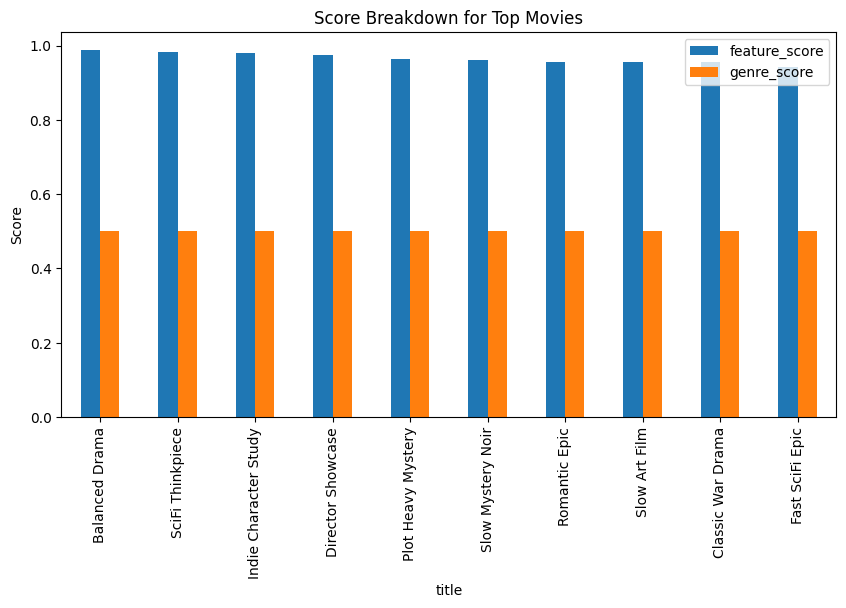

In [5]:
results.set_index("title")[["feature_score", "genre_score"]].plot(kind="bar", figsize=(10,5))
plt.title("Score Breakdown for Top Movies")
plt.ylabel("Score")
plt.show()


In [6]:
# This cell computes cosine similarity EXACTLY like the recommender engine
# (baseline-only here: ratings=None)

baseline = recommender.baseline_user_profile(user_weights, ideal_rating=5.0)
baseline = recommender.apply_mask(baseline, user_weights)

# If you want to see discovery smoothing's effect on similarity, uncomment:
# baseline = recommender.discovery_user_profile(baseline, ideal_rating=5.0, alpha=0.85)

df_tmp = df.copy()
df_tmp["cosine_score"] = df_tmp.apply(
    lambda row: recommender.cosine_similarity(
        baseline,
        recommender.movie_vector(row, pacing_pref=pacing_pref)
    ),
    axis=1
)

df_tmp.sort_values("cosine_score", ascending=False)[["title", "cosine_score"]].head(10)


,title,cosine_score
2,Balanced Drama,0.987346
16,SciFi Thinkpiece,0.981658
8,Indie Character Study,0.979559
19,Director Showcase,0.974684
12,Crime Investigation,0.968702
5,Plot Heavy Mystery,0.963885
14,Slow Mystery Noir,0.962160
10,Romantic Epic,0.955059
0,Slow Art Film,0.955018
17,Classic War Drama,0.954669


In [7]:
normal, normal_meta = recommender.recommend_movies(
    df, user_weights, preferred_genres, pacing_pref="fast", discovery_mode=False, top_n=10
)
discovery, discovery_meta = recommender.recommend_movies(
    df, user_weights, preferred_genres, pacing_pref="fast", discovery_mode=True, top_n=10
)

normal = normal.copy()
discovery = discovery.copy()
normal["mode"] = "normal"
discovery["mode"] = "discovery"

pd.concat([normal, discovery])[["title", "final_score", "mode"]]


,title,final_score,mode
2,Balanced Drama,0.841142,normal
16,SciFi Thinkpiece,0.837161,normal
8,Indie Character Study,0.835691,normal
19,Director Showcase,0.832278,normal
5,Plot Heavy Mystery,0.824719,normal
14,Slow Mystery Noir,0.823512,normal
10,Romantic Epic,0.818541,normal
0,Slow Art Film,0.818512,normal
17,Classic War Drama,0.818268,normal
4,Fast SciFi Epic,0.809503,normal


In [8]:
# Continuous learning demo (Option C)
# Simulate that the user liked a few fast / action-ish movies.

ratings = {
    5: 5,   # Fast SciFi Epic
    10: 4,  # High Energy Thriller
    2: 4    # Action Blockbuster
}

learned_results, learned_meta = recommender.recommend_movies(
    df,
    user_weights,
    preferred_genres,
    pacing_pref=pacing_pref,
    discovery_mode=False,
    top_n=10,
    ratings=ratings,
    like_threshold=4,
    K=5
)

display(learned_results[["title", "final_score", "feature_score", "genre_score"]])

print("Learning Info (after simulated ratings):")
print(f"- liked movies used: {learned_meta['n_likes']}")
print(f"- beta (baseline weight): {learned_meta['beta']:.3f}")
print(f"- final user profile: {np.round(learned_meta['final_profile'], 3)}")


,title,final_score,feature_score,genre_score
4,Fast SciFi Epic,0.847653,0.996647,0.5
9,High Energy Thriller,0.844561,0.992230,0.5
2,Balanced Drama,0.836469,0.980670,0.5
1,Action Blockbuster,0.833471,0.976388,0.5
8,Indie Character Study,0.823472,0.962103,0.5
10,Romantic Epic,0.818868,0.955526,0.5
16,SciFi Thinkpiece,0.818092,0.954417,0.5
5,Plot Heavy Mystery,0.815058,0.950083,0.5
19,Director Showcase,0.811091,0.944415,0.5
17,Classic War Drama,0.808050,0.940071,0.5


Learning Info (after simulated ratings):
- liked movies used: 3
- beta (baseline weight): 0.625
- final user profile: [2.072 2.033 2.368 1.704 2.197]
